# Toxic Release Sites

The goal of this notebook (and project) is to identify Toxic Release Sites that are located within 5-miles of a medium to large sized town/city in Kentucky.

This notebook can be re-used to identify other data that fall within a certain buffer radius of a separate piece of data (Example: Identify all landfills within 1,000 meters of a lake).

Notebook Objectives:
- Import data from a remote source
- Inspect the data
- Make a local copy
- Remove any unwanted columns
- Prepare data for export
- Export the data to a json file

Notebook and map created by [Kevin Dohner](https://github.com/KDoh12)

## Import the required packages

In [1]:
# Import initial python packages
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# This suppresses warnings which can help keep things looking clean
import warnings
warnings.simplefilter(action='ignore')

### Import, inspect and clone down the data

It is good practice to make a local copy of the data before you start manipulating it. This can help keep everything cohesive and allows for you to have a copy of the data in case it gets taken down, or modified before you are finished working on it.

### Import the data

This is the first step whenever working with data as you need data to work with!

Data Sources:
- Populated Places from [Natural Earth](https://www.naturalearthdata.com/)
- State Boundaries from [U.S. Census](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2017.html#list-tab-GJZM0THQ9XOOTZ5UEB)
- Toxic Release Inventory from [data.world](https://data.world/dhs/epa-er-toxic-release-inventory)

In [2]:
# Import the needed datasets
# I am importing populated places and state boundary data as it will be used to obtain my end json file
places_raw = gpd.read_file('https://naciscdn.org/naturalearth/10m/cultural/ne_10m_populated_places.zip')
states_raw = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')
tri_raw = pd.read_csv('https://query.data.world/s/3b3oi57gti4qhoexmg74sdc3ftz2te', index_col='FID')

# This outputs the CRS of the 2 shapefiles I imported
# Note they are 2 different coordinate systems
# This will be addressed at a later point
print(places_raw.crs)
print(states_raw.crs)

epsg:4326
epsg:4269


### Create a GeoDataFrame

In order to use our csv data with geopandas, we must create a GeoDataFrame from the info found within it.

In [3]:
# Create a GeoDataFrame from the CSV data and assign the CRS to WGS84
geoms = [Point(xy) for xy in zip(tri_raw.X, tri_raw.Y)]
crs = "EPSG:4326"
tri_geo = gpd.GeoDataFrame(tri_raw, crs=crs, geometry=geoms)

### Inspect the data

It is always a good idea to inspect data to make sure it has what you are looking for before you make a local copy

In [4]:
# Get an idea of what data is in the Toxic Release Inventory
tri_geo.head()

,X,Y,REGISTRY_I,PRIMARY_NA,LOCATION_A,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,POSTAL_COD,...,LAST_REPOR,FAC_URL,PGM_SYS_ID,PGM_SYS_AC,INTEREST_T,ACTIVE_STA,PUBLIC_IND,PROGRAM_UR,PGM_REPORT,geometry
FID,,,,,,,,,,,,,,,,,,,,,
15001,-119.86581,34.43024,110002916836,LITTON GUIDANCE AND CONTROL SYSTEMS,6769 HOLLISTER AVENUE,GOLETA,SANTA BARBARA,06083,CA,93117-3001,...,2002-06-25T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,93118LTTNS6769H,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-119.86581 34.43024)
15002,-81.23533,41.75468,110000385921,UNIROYAL CHEMICAL CO INC,720 FAIRPORT NURSERY ROAD,PAINESVILLE,LAKE,39085,OH,44077-4462,...,2002-06-24T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,44077NRYLC720FA,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-81.23533 41.75468)
15003,-83.44870,41.66416,110000384334,AUTONEUM NORTH AMERICA INC,645 N. LALLENDORF RD.,OREGON,LUCAS,39095,OH,43616,...,2012-06-29T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,43616GLBND645LA,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-83.44870 41.66416)
15004,-117.38566,47.75197,110000491478,TRAVIS PATTERN,1413 EAST HAWTHORNE ROAD,SPOKANE,SPOKANE,53063,WA,99218-3100,...,2014-05-30T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,99207TRVSPE1413,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-117.38566 47.75197)
15005,-77.40728,37.58766,110022532623,ENNIS PAINT-RICHMOND,4400 VAWTER AVE,RICHMOND,HENRICO,51087,VA,23222,...,2014-06-25T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,23222DGLSC4400V,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet,POINT (-77.40728 37.58766)


In [5]:
# As you can see, this dataset has a lot of columns that we don't need
# For now we will keep so we can have a whole copy
# We will trim it down in a bit
tri_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 57630 entries, 15001 to 57000
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   X           57630 non-null  float64 
 1   Y           57630 non-null  float64 
 2   REGISTRY_I  57630 non-null  int64   
 3   PRIMARY_NA  57630 non-null  object  
 4   LOCATION_A  57630 non-null  object  
 5   CITY_NAME   57630 non-null  object  
 6   COUNTY_NAM  57630 non-null  object  
 7   FIPS_CODE   57630 non-null  object  
 8   STATE_CODE  57630 non-null  object  
 9   POSTAL_COD  57630 non-null  object  
 10  LATITUDE83  57630 non-null  float64 
 11  LONGITUDE8  57630 non-null  float64 
 12  HUC8_CODE   57630 non-null  object  
 13  ACCURACY_V  57630 non-null  int64   
 14  COLLECT_MT  57630 non-null  object  
 15  REF_POINT_  57630 non-null  object  
 16  CREATE_DAT  57630 non-null  object  
 17  UPDATE_DAT  56861 non-null  object  
 18  LAST_REPOR  57488 non-null  object

### Clone and reload the data

In [6]:
# Write the raw data to a file so it can be worked on offline
# Note that you must have a /data directory already for this code to work
# You can always modify the output location if necessary
places_raw.to_file('./data/populated_places.json', driver='GeoJSON', encoding='utf-8')
states_raw.to_file('./data/states.json', driver='GeoJSON', encoding='utf-8')
tri_geo.to_file('./data/toxic_release_inventory.json', driver='GeoJSON', encoding='utf-8')

In [7]:
# Read the downloaded data back into the notebook
places = gpd.read_file('data/populated_places.json')
states = gpd.read_file('data/states.json')
tri = gpd.read_file('data/toxic_release_inventory.json')

## Remove unwanted columns

We can clean up our data some so that the finished product isn't so big and full of data that we don't need

In [8]:
# As we saw earlier, there were a bunch of columns that we just don't need
# We can drop a lot of them
tri.drop(['REGISTRY_I', 'POSTAL_COD', 'LATITUDE83', 'LONGITUDE8', 'HUC8_CODE', 'ACCURACY_V', 'COLLECT_MT', 'REF_POINT_', 'CREATE_DAT', 'UPDATE_DAT', 'LAST_REPOR', 'FAC_URL', 'PGM_SYS_ID', 'PGM_SYS_AC', 'INTEREST_T', 'ACTIVE_STA', 'PUBLIC_IND', 'PROGRAM_UR', 'PGM_REPORT'], axis=1, inplace=True)
tri.head()

,FID,X,Y,PRIMARY_NA,LOCATION_A,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,geometry
0,15001,-119.86581,34.43024,LITTON GUIDANCE AND CONTROL SYSTEMS,6769 HOLLISTER AVENUE,GOLETA,SANTA BARBARA,06083,CA,POINT (-119.86581 34.43024)
1,15002,-81.23533,41.75468,UNIROYAL CHEMICAL CO INC,720 FAIRPORT NURSERY ROAD,PAINESVILLE,LAKE,39085,OH,POINT (-81.23533 41.75468)
2,15003,-83.44870,41.66416,AUTONEUM NORTH AMERICA INC,645 N. LALLENDORF RD.,OREGON,LUCAS,39095,OH,POINT (-83.44870 41.66416)
3,15004,-117.38566,47.75197,TRAVIS PATTERN,1413 EAST HAWTHORNE ROAD,SPOKANE,SPOKANE,53063,WA,POINT (-117.38566 47.75197)
4,15005,-77.40728,37.58766,ENNIS PAINT-RICHMOND,4400 VAWTER AVE,RICHMOND,HENRICO,51087,VA,POINT (-77.40728 37.58766)


## Prepare data for export

### Create a buffer

In this section we will create a buffer which we will use later to pull out our Toxic Release Sites.

For help with coordinate systems and finding the proj4 text like the ones below, visit [epsg.io](https://epsg.io/)

In [9]:
# Switch to an equidistant conic project to ensure accurate measurements
# This is important since we are wanting to create accurate buffer distances
# Note that the proj4 line tells us that this new CRS uses meters as it's units
states_eqdc = states.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
places_eqdc = places.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs ')
tri_eqdc = tri.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')


In [10]:
# Create a new column and make it equal the buffer result to retain the attribute data
# Buffer distance below is 5-miles converted to meters since the CRS is now in meters
places_eqdc['buffer'] = places_eqdc.buffer(8046.72)

In [11]:
# Set the buffer column as the active geometry
# This replaces it's "point" geometry with a "polygon" geometry
places_eqdc = places_eqdc.set_geometry('buffer')

### Pull out data for Kentucky

In this section we will find all of our populated places that are located in Kentucky, which we will then use to find all the Toxic Release Sites that are located within 5-miles of populated towns/cities in Kentucky.

In [12]:
# This pulls Kentucky out of the states layer
ky_eqdc = states_eqdc[states_eqdc['STATEFP'] == '21']

# This sets the kentucky polygon as a single polygon instead of a multipart polygon
# In order to use the .intersect() method it must be a single polygon
ky_poly = ky_eqdc.unary_union

In [13]:
# This uses the .intersect() method to pull just the populated places that are within Kentucky
places_eqdc_ky = places_eqdc[places_eqdc.geometry.intersects(ky_poly)]

# This pulls just the Toxic Release Sites that are within Kentucky
tri_eqdc_ky = tri_eqdc[tri_eqdc.geometry.intersects(ky_poly)]

### Visualize data

This is a good moment to visualize what we have so far. We have taken our data which spans the United States, and in the case of the populated places layer, the entire world, and condensed it down to just Kentucky.

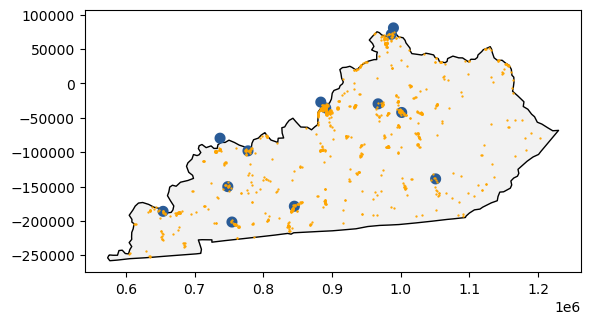

In [14]:
fig, ax = plt.subplots()

# This will display the state of Kentucky with a light gray fill and black border
ky_eqdc.plot(ax=ax, color='#f2f2f2', edgecolor='000000', zorder=0);

# This will display the populated places layer as a blue dot
# Note that the dot is actually the 5-mile buffer
places_eqdc_ky.plot(ax=ax, color='#295b97', zorder=1);

# This will display the Toxic Release Sites as a orange dot
tri_eqdc_ky.plot(ax=ax, color='orange', markersize=.4, zorder=2);

### Find the Toxic Release Sites

We are now ready to find all the Toxic Release Sites that are within 5-miles of a populated place.

In [15]:
# Convert the populated places layer into a single polygon
# Remember this is so we can use the .intersect() method
places_poly = places_eqdc_ky.unary_union

# Use the .intersect() method to find all sites within the 5-mile buffer
tri_eqdc_places = tri_eqdc_ky[tri_eqdc_ky.geometry.intersects(places_poly)]

### Visualize data

Let's take a look at our data again to ensure we got what we wanted

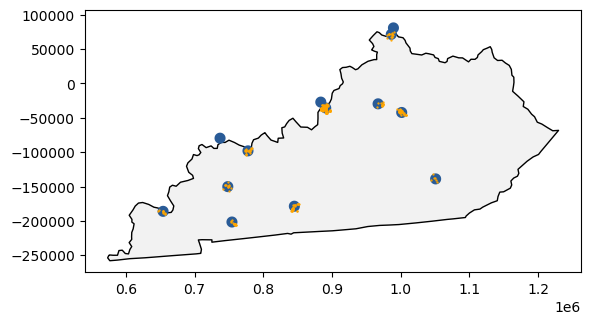

In [16]:
fig, ax = plt.subplots()

# This will display the state of Kentucky with a light gray fill and black border
ky_eqdc.plot(ax=ax, color='#f2f2f2', edgecolor='000000', zorder=0);

# This will display the populated places layer as a blue dot
# Note that the dot is actually the 10-mile buffer
places_eqdc_ky.plot(ax=ax, color='#295b97', zorder=1);

# This will display the Toxic Release Sites as a orange dot
tri_eqdc_places.plot(ax=ax, color='orange', markersize=.4, zorder=2);

## Export the data

Now that we have the data that we came for, it is now time to export it so we can use it in a web map!

### Change the CRS

Since we no longer need accurate measurements, we can change our coordinate system. Your needs may vary, but for this project, I will use EPSG:4326, WGS84.

In [17]:
# Change the CRS to the WGS84 coordinate system
tri_wgs_places = tri_eqdc_places.to_crs('+proj=longlat +datum=WGS84 +no_defs +type=crs')

# Check the CRS of the layer
tri_wgs_places.crs

<Geographic 2D CRS: +proj=longlat +datum=WGS84 +no_defs +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Write to file

This is the final step, we just need to simply write the data out to a new GeoJSON file!

In [18]:
# Output the data to a new json file to then put in the map
# Note that the /map/data directory needs to already exist
tri_wgs_places.to_file('../map/data/toxic-sites-5mile.json', driver='GeoJSON')

### GeoJSON Tip

If you want to test that your output is correct, and usable in things such as web maps, upload your newly created file to [geojson.io](https://geojson.io).

This website will take your GeoJSON file and display it on a globe if everything checks out.